# Capstone Project - The Battle of the Neighborhoods (Week 2)
   ### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The goal of this Capstone project is to explore, analyze and select the best locations in the city of New York to open a new African restaurant. Using Data Science methodology and tools, this project aims to provide solutions to answer the business question: Where in the city of New York, should the investor open an African Restaurant?

## Data <a name="data"></a>

### To solve the problem, we will need the following data:

New York City data containing the neighborhoods and boroughs. Latitude and longitude coordinates of those neighborhoods. This is required to plot the map and get the venue data. Venue data, particularly data related to restaurants. We are going to use this data to perform further analysis of the neighborhoods.

### Data Source and methods to extract them

New York City data containing the neighborhoods and boroughs will be obtained from the open data source: https://cocl.us/new_york_dataset. After it, we will get the geographical coordinates of the neighborhoods (latitude and longitude) using Python Geocoder package.

Finally, we will use Foursquare API to get the venue data for the neighborhoods defined at the previous step. Foursquare has one of the largest databases of 105+ million places and over 125,000 developers use this application. Foursquare API provides many categories of the venue data; we are particularly interested in the restaurant data to solve the business problem defined above.

This project will require using of many data science skills, from web scrapping (open source dataset), working with API (Foursquare), data cleaning, data wrangling, to map visualization (Folium). 


#### First let's import all the libraries we need for this project

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


## Methodology <a name="methodology"></a>

•	Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.
•	FourSquare be used to locate all venues and then filtered by African restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.
•	Data will be sorted based on rankings.
•	Finally, the data be will be visually assessed using graphing from Python libraries.


In [2]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'BHZCYXGUI3AZ3SFVBHEYG22H2JPBIUOKSILJO4E43KTEUKBA' # your Foursquare ID
CLIENT_SECRET = '5QFMNBDCPS5TQAAWBMFEGRBJ4A2TK4MCASRGPHYO0GLZO1TE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BHZCYXGUI3AZ3SFVBHEYG22H2JPBIUOKSILJO4E43KTEUKBA
CLIENT_SECRET:5QFMNBDCPS5TQAAWBMFEGRBJ4A2TK4MCASRGPHYO0GLZO1TE


#### Next we define the functions we are going to use in this project

In [3]:
# get geo location of address
def geo_location(address):    
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
#locate available vanues in York 
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

#### Let's get initial NYC data

In [7]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
ny_data.shape

(306, 4)

## Analysis <a name="analysis"></a>

#### Next let's explore and analyse the data to get more insights: compare neigborhoods as each scaleup with each other

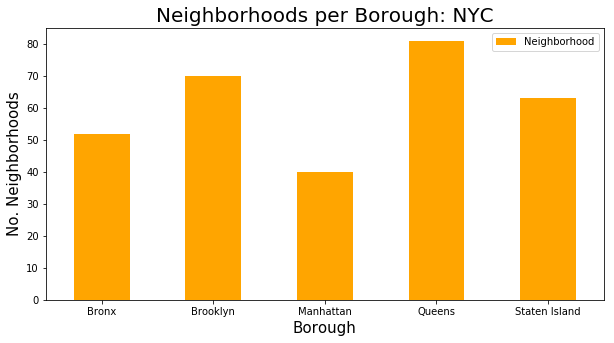

In [9]:
clr = "orange"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

#### Let's see how many African restaurants are there in each neighborhood and borough.

In [10]:
# queens has most neighborhoods
# prepare neighborhood list that contains african restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_restaurants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(ny_data),')','African Restaurants in '+Neighborhood+', '+Borough+':'+str(len(african_restaurants)))
    print(row)
    for resturant_detail in african_restaurants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) African Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) African Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) African Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) African Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) African Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) African Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) African Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) African Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) African Restaurants in Norwood, Bronx:0
['

( 68 / 306 ) African Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) African Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) African Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) African Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) African Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) African Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) African Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) African Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) African Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) African Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) African Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) African Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) African Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) African Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) African Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) African Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) A

( 198 / 306 ) African Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) African Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) African Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) African Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) African Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) African Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) African Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) African Restaurants in South Bea

( 259 / 306 ) African Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) African Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) African Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) African Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) African Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) African Restaurants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) African Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) African Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120

In [11]:
african_rest_ny.to_csv('african_rest_ny_tocsv1.csv')

In [12]:
african_ny = pd.read_csv('african_rest_ny_tocsv1.csv')
african_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant
1,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem
2,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna
3,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant


In [13]:
african_rest_ny.shape

(4, 4)

This shows that we 4 African Restaurants across New York City

#### The graph below shows which Borough has the highest number of African Restaurants across New York

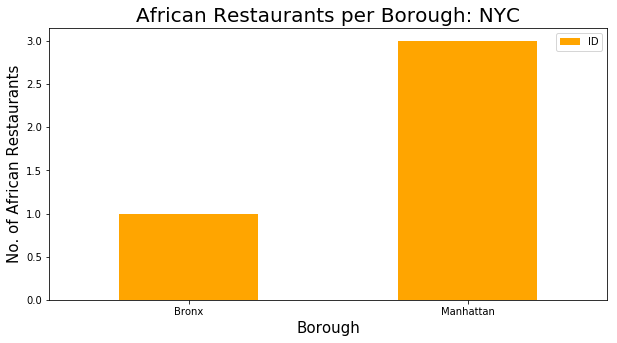

In [14]:
african_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('African Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of African Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

The above graphic shows that Manhattan has the highest numbers of African restaurants across New York City. Obviously African Americans are more there.

#### African Restaurants by neigborhoods

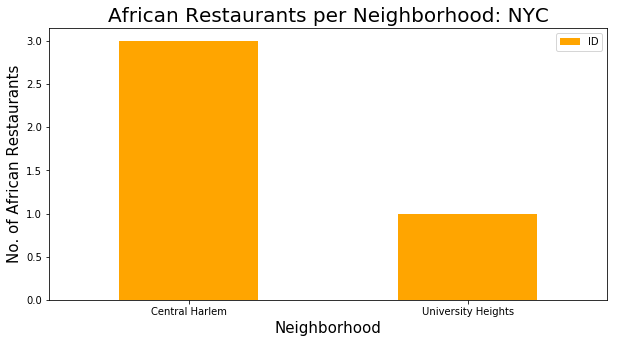

In [15]:
NOofNeigh = 6 # top 6 numbers 
african_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('African Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of African Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Central Harlem in Manhattan has more concentrations of African Restaurants

In [16]:
african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

,Borough,Neighborhood,ID,Name
1,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem
2,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna
3,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant


Central Harlem with a total of 3 African restaurants 

#### Now let's rank the restaurants to explore more details

In [17]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
african_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '603efca026b85a1e73e416fd'}, 'response': {'venue': {'id': '4c2f8b1b7cc0c9b6a1eaeb9a', 'name': 'Accra Resturant', 'contact': {}, 'location': {'address': '2021-2039 Davidson Ave', 'lat': 40.85387109221504, 'lng': -73.90842103412992, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85387109221504, 'lng': -73.90842103412992}], 'postalCode': '10453', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2021-2039 Davidson Ave', 'Bronx, NY 10453', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/accra-resturant/4c2f8b1b7cc0c9b6a1eaeb9a', 'categories': [{'id': '4bf58dd8d48988d1c8941735', 'name': 'African Restaurant', 'pluralName': 'African Restaurants', 'shortName': 'African', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/african_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'c

{'meta': {'code': 200, 'requestId': '603efca11734f052cc3fe740'}, 'response': {'venue': {'id': '4c2fdced452620a120551e0f', 'name': 'Keur Sokhna', 'contact': {'phone': '2123685007', 'formattedPhone': '(212) 368-5007'}, 'location': {'address': '2249 Adam Clayton Powell Jr Blvd', 'crossStreet': '133rd', 'lat': 40.81355599557865, 'lng': -73.94500077822643, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81355599557865, 'lng': -73.94500077822643}, {'label': 'entrance', 'lat': 40.813506, 'lng': -73.944707}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2249 Adam Clayton Powell Jr Blvd (133rd)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/keur-sokhna/4c2fdced452620a120551e0f', 'categories': [{'id': '4bf58dd8d48988d1c8941735', 'name': 'African Restaurant', 'pluralName': 'African Restaurants', 'shortName': 'African', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/a

{'meta': {'code': 200, 'requestId': '603efca2120f9a5edb49038c'}, 'response': {'venue': {'id': '4a9ea132f964a520ad3a20e3', 'name': 'Africa Kine Restaurant', 'contact': {'phone': '2126669400', 'formattedPhone': '(212) 666-9400'}, 'location': {'address': '2267 7th Ave', 'crossStreet': 'at Adam Clayton Powell Junior Blvd', 'lat': 40.8137280306601, 'lng': -73.94442558288574, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8137280306601, 'lng': -73.94442558288574}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2267 7th Ave (at Adam Clayton Powell Junior Blvd)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/africa-kine-restaurant/4a9ea132f964a520ad3a20e3', 'categories': [{'id': '4bf58dd8d48988d1c8941735', 'name': 'African Restaurant', 'pluralName': 'African Restaurants', 'shortName': 'African', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/african_', 'suffix': '.

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,6.8,3
1,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem,107,8.6,31
2,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna,12,7.7,8
3,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant,35,7.3,33


Append new data to the csv file

In [18]:
african_rest_stats_ny.to_csv('african_rest_stats_ny_csv.csv') 

In [19]:
african_rest_stats_ny.shape # new size of file

(4, 7)

In [20]:
# To see what values we have in our DataFrame
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
Borough         4 non-null object
Neighborhood    4 non-null object
ID              4 non-null object
Name            4 non-null object
Likes           4 non-null object
Rating          4 non-null float64
Tips            4 non-null object
dtypes: float64(1), object(6)
memory usage: 304.0+ bytes


Now let's convert values of likes and tips to floats for further analysis

In [21]:
african_rest_stats_ny['Likes'] = african_rest_stats_ny['Likes'].astype('float64')
african_rest_stats_ny['Tips'] = african_rest_stats_ny['Tips'].astype('float64')
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
Borough         4 non-null object
Neighborhood    4 non-null object
ID              4 non-null object
Name            4 non-null object
Likes           4 non-null float64
Rating          4 non-null float64
Tips            4 non-null float64
dtypes: float64(3), object(4)
memory usage: 304.0+ bytes


In [22]:
african_rest_stats_ny.describe()

,Likes,Rating,Tips
count,4.000000,4.000000,4.000000
mean,40.750000,7.600000,18.750000
std,45.668187,0.761577,15.456929
min,9.000000,6.800000,3.000000
25%,11.250000,7.175000,6.750000
50%,23.500000,7.500000,19.500000
75%,53.000000,7.925000,31.500000
max,107.000000,8.600000,33.000000


In [23]:
# Resturant with maximum Likes
african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood              Central Harlem
ID              53e01975498e78c0915599bf
Name                 Ponty Bistro Harlem
Likes                                107
Rating                               8.6
Tips                                  31
Name: 1, dtype: object

In [24]:
# Resturant with maximum Ratings
african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood              Central Harlem
ID              53e01975498e78c0915599bf
Name                 Ponty Bistro Harlem
Likes                                107
Rating                               8.6
Tips                                  31
Name: 1, dtype: object

In [25]:
# Resturant with maximum Tips
african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood              Central Harlem
ID              4a9ea132f964a520ad3a20e3
Name              Africa Kine Restaurant
Likes                                 35
Rating                               7.3
Tips                                  33
Name: 3, dtype: object

#### Now let's visualize the neiborhoods based on average ratings of restaurants 

In [26]:
ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
0,Central Harlem,7.866667
1,University Heights,6.800000


Average ratings by each Borough below

In [27]:
ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,7.866667
0,Bronx,6.800000


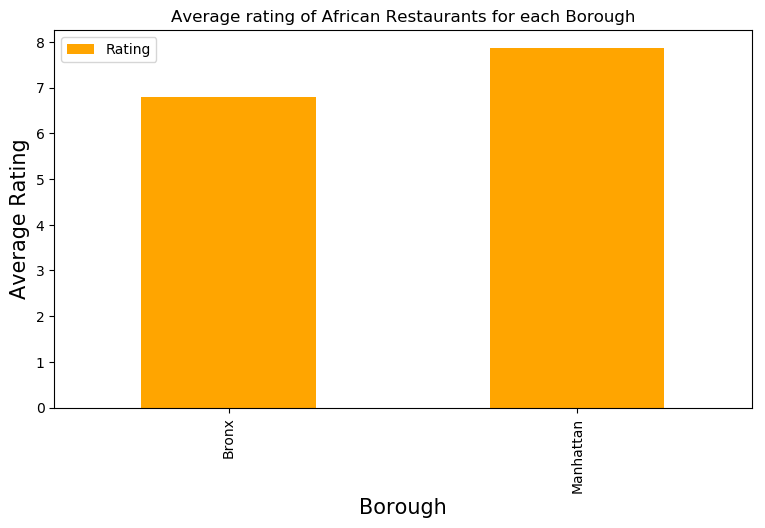

In [28]:
# visualize result
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of African Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [29]:
# join this Dataset to original New York data to get longitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Central Harlem,40.815976,-73.943211,7.866667
1,Bronx,University Heights,40.855727,-73.910416,6.800000


In [30]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_map

In [31]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

## Results and Discussion <a name="results"></a>

Our result shows that Manhattan and Bronx have the best concentration of african restaurants and on average the best rated as well. Bronx has the least number of african restaurants compare to Manhattan. On analysing further we saw that Central Harlem of Manhattan and University Heights of Bronx neighborhoods are where these african restaurants are located with Central Harlem having the highest. In terms of likes and ratings, Ponty Bistro Harlem restaurant has the highest and for the most tips, Africa Kine Restaurant comes out top. Based on the above information, I would state that Manhattan and Bronx are the best locations for African cuisine in NYC. In order to be successful in siting a restaurant, I would recommend opening an African Restaurant in Bronx since it has the least number of restaurants compare to Manhattan for the sake of less competition. The result shows that Bronx has only one restaurant i.e Accra Restaurant in University Heights neighborhood hence competition worries will be very low.  

## Conclusion <a name="conclusion"></a>

Based on our analysis, this project was able to determine the suitable location to site an African Restaurant i.e Bronx borough being that it has least concentration of African restaurants compared to Manhattan. For that reason competition would be very low and better chances of success. Finally in terms of likes, from the analysis presented I would go to Ponty Bistro Harlem because much people seems to prefer it. 